# CO416 - Machine Learning for Imaging

## Coursework 1 - Classification

In this coursework you will be applying the material taught in the course up to and including lecture 4.

$\mathbf{NOTE - \text{READ THIS}:}$ 
- During this coursework you will be asked to comment on the performance of various aspects of the models you develop. The discussion should be done along the following lines:
    - Maximum 100 words of discussion - You are asked to be brief and on point, platitudes and excessive writing will be penalized
    - You should mention effects on accuracy, and computational requirements i.e. time and computational complexities. Empirical arguments are accepted 
    
- When you are asked to change the hyperparamenters, validate the performance of your classifier and explicitly state the optimal hyperparameters you found and their accuracy

## Question 1 (50 Points) 

In this question we will use a toy spiral dataset as generated by the [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function of sklearn

1) Create a dataset of 1000 points with a noise value of 0.1 and random_state=0 and augment it using polynomial features (recommended degree 10-15) (4 points)

In [1]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier

import numpy as np

In [2]:
X, Y = make_moons(1000, noise=0.3, random_state=0)

pol_transform = PolynomialFeatures(degree=15)
X_extended = pol_transform.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_extended, Y, test_size=0.20, random_state=42)

2) Visualize your input data - the first 2 dimensions would suffice  (3 points)



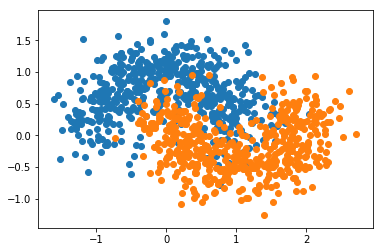

In [3]:
def show_data():
    X_0 = X[np.isin(Y, 0)]
    X_1 = X[np.isin(Y, 1)]

    plt.scatter(X_0[:,0], X_0[:,1])
    plt.scatter(X_1[:,0], X_1[:,1])

    plt.show()
show_data()

3) Use a Decision Tree to classify the data (5 points)



In [4]:
# Decision Tree, using Gini

decision_tree_gini = DecisionTreeClassifier(criterion='gini', random_state=0)
decision_tree_gini.fit(x_train, y_train)
gini_acc = decision_tree_gini.score(x_test, y_test)

4) Try both Gini Impurity and Information Gain, which performs better? What is the difference between them? (4 points)

In [5]:
decision_tree_entropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
decision_tree_entropy.fit(x_train, y_train)
entropy_acc = decision_tree_entropy.score(x_test, y_test)

print("Gini accuracy: {} versus Information Gain accuracy {}".format(gini_acc, entropy_acc))

Gini accuracy: 0.815 versus Information Gain accuracy 0.825


Information Gain provides better accuracy on this dataset. This is expected, as it usually favors smaller partitions with many distinct values, while Gini provides better results on larger datasets. Also, for our case we only have 2 categories, within one moon or the other, making the Information Gain approach unbiased. The Gini Index must be minimized (it indicates how mixed the classes are following the split), while IG must be maximized (gain as much information on a step as possible).

5) Perform classification using a tree depth of 1-20. Plot the accuracy versus tree depth. (5 points)



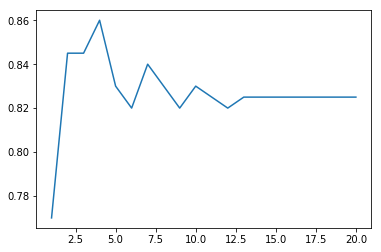

In [6]:
depth_sizes = range(1, 21)

accuracies = []
for depth in depth_sizes:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=0)
    dt.fit(x_train, y_train)
    accuracies.append(dt.score(x_test, y_test))
    
plt.plot(depth_sizes, accuracies)
plt.show()

6) How does the depth of a tree affect performance and computational burden? (1 points)



We can observe that the highest accuracy is reached at the relatively low depth of 4. That is because the distribution of our input data is quite simplistic and there are only 2 classes to be classified, so a simpler model fits the data best. When we increase the depth we start to overfit to the training data so our model doesn't generalise well. Also a higher depth means a bigger computational overhead, as every level on the tree is basically another if statement that needs to be executed. This might not seem much if you take 1 example, but if you have a forest with 100+ trees and 100k+ samples, the computational overhead will be noticeable.

7) Use Bootstrap Classifier to classify your data, base estimator should be a decision tree. Tune hyperparameters of tree depth, n_of estimators, max_samples and bootstrap. Plot accuracy versus different hyperparameters. (7 points)



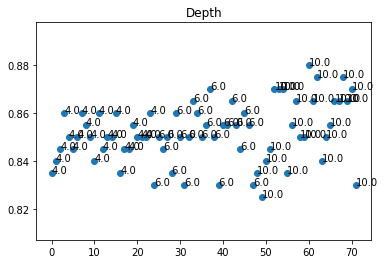

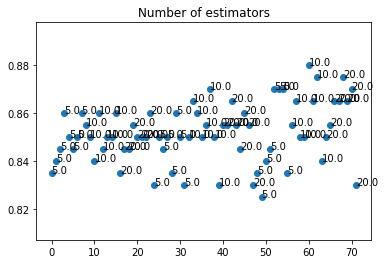

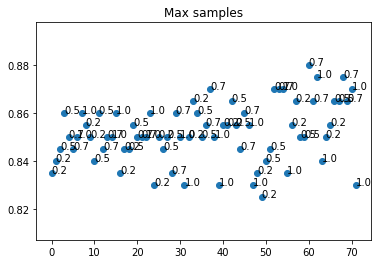

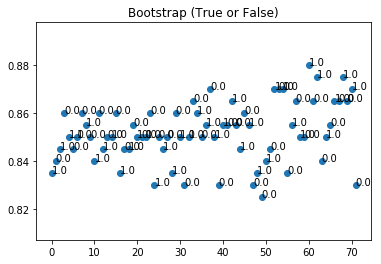

In [7]:
depths = [4, 6, 10]
bootstrap = [True, False]
n_estimators = [5, 10, 20]
max_samples = [0.2, 0.5, 0.7, 1.0]

configs = []

for depth in depths:
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=0)
    for n_est in n_estimators:
        for max_s in max_samples:
            for bs in bootstrap:    
                bs_clr = BaggingClassifier(base_estimator=dt, n_estimators=n_est, max_samples=max_s, bootstrap=bs, random_state=0)
                bs_clr.fit(x_train, y_train)
                bs_acc = bs_clr.score(x_test, y_test)
                configs.append(np.array([depth, n_est, max_s, bs, bs_acc]))

configs = np.array(configs)

for idx, txt in enumerate(["Depth", "Number of estimators", "Max samples", "Bootstrap (True or False)"]):
    plt.scatter(list(range(len(configs))), configs[:,4])
    for i in range(len(configs)):
        plt.annotate(configs[i][idx], (i, configs[i][4]))
    plt.title(txt)
    plt.show()


8) Why do we use Bootstraping when we create our datasets? Did you use replacement ? Why ? (1 points) 

Bootstraping is used to uncorrelate different instances of the same classifier sampling from the same dataset. For large datasets, sampling using Bootstrap will approximate any distribution estimated from the full population. 

In our case, we have tuned the 'bootstrap' parameter of the Bagging Classifier to offer results with both replacement and without. The reason for using replacement is to provide asymmetry (different datasets) to each instance - these instances will learn different features better, providing more chances for the overall system to predict with a higher accuracy.

9)  Use a Decision Forest to classify the dataset (4 points)



In [8]:
rf = RandomForestClassifier(criterion='entropy', n_estimators=35, max_depth=10, bootstrap=True, random_state=0)
rf.fit(x_train, y_train)
rf_acc = rf.score(x_test, y_test)
print(rf_acc)

0.86


10) Modulate the number of trees to 1-99 with a step of 10. Plot accuracy versus number of trees. (4 points)



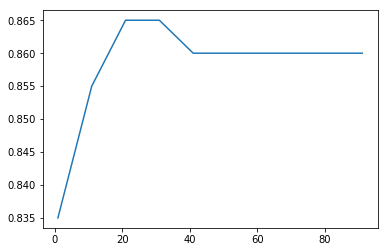

In [9]:
no_of_estimators = range(1, 100, 10)

accuracies = []
for n_estimator in no_of_estimators:
    rf = RandomForestClassifier(criterion='entropy', n_estimators=n_estimator, max_depth=10, random_state=0)
    rf.fit(x_train, y_train)
    rf_acc = rf.score(x_test, y_test)
    accuracies.append(rf_acc)

plt.plot(no_of_estimators, accuracies)
plt.show()

11) Modulate the depth of  the trees from 1 to 20 - use best number of trees from above. Plot the accuracy versus depth. (4 points)



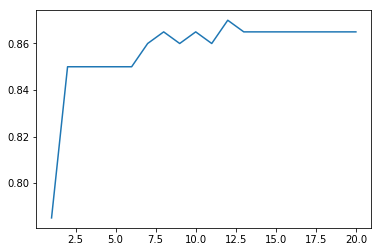

In [10]:
depths = range(1, 21)

accuracies = []
for depth in depths:
    rf = RandomForestClassifier(criterion='entropy', n_estimators=20, max_depth=depth, bootstrap=True, random_state=0)
    rf.fit(x_train, y_train)
    rf_acc = rf.score(x_test, y_test)
    accuracies.append(rf_acc)
    
plt.plot(depths, accuracies)
plt.show()

12) Comment on the performance change while you modulate depth of trees and number of trees (3 points)

Observing the depth of the trees we notice that there seems to be almost continuous improvement in terms of accuracy from depth 1 to 12, and then the accuracy plateaus. This might seem counter-intuivie, as in previous experiments the DT with depth 4 yeilded the best results, however there is a simple explanation. Deeper decision trees have low bias and high variance, but when using bagging the variance is reduced by the voting process, so when using bagging it makes sense to favour weak learners which have good bias, even if they have lower variance. The ideal number of estimators in our model is 20-30, afterwards the accuracy slightly decreases and then it plateaus. We believe the reason accuracy is not directly proportional to the number of estimators is because after a certain amount (30 in our case) the trees are too correlated. This can be both because of the low amount of data and because we don't split our data well enough when training the estimators.  

13) Visualise how the classification split is done in relation to the data both for Decision Tree and Decision Forest (3 points)

In [11]:
from sklearn.manifold.t_sne import TSNE
from sklearn.neighbors.classification import KNeighborsClassifier

def plot_decision_boundary(model, X, Y, x_poly):
    Y_pred=model.predict(x_poly)
    # create meshgrid
    resolution = 100 # 100x100 background pixels
    X2d_xmin, X2d_xmax = np.min(X[:,0]), np.max(X[:,0])
    X2d_ymin, X2d_ymax = np.min(X[:,1]), np.max(X[:,1])
    xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

    # approximate Voronoi tesselation on resolution x resolution grid using 1-NN
    background_model = KNeighborsClassifier(n_neighbors=1).fit(X, Y_pred) 
    voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
    voronoiBackground = voronoiBackground.reshape((resolution, resolution))

    #plot
    plt.contourf(xx, yy, voronoiBackground)
    plt.scatter(X[:,0], X[:,1], c=Y)
    plt.show()

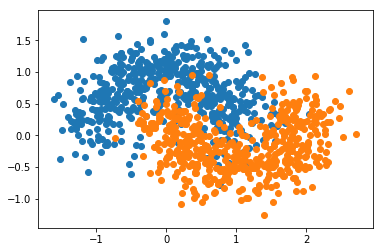

DecisionTreeClassifier accuracy: 0.86


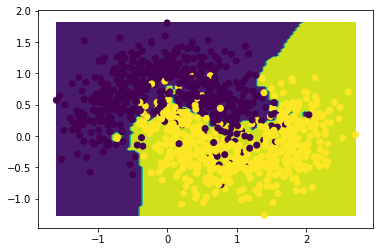

RandomForestClassifier accuracy: 0.87


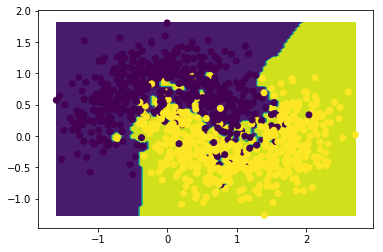

In [15]:
show_data()

model = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=0)
model.fit(x_train, y_train)
print("DecisionTreeClassifier accuracy: " + str(model.score(x_test, y_test)))
plot_decision_boundary(model, X, Y, X_extended)

model = RandomForestClassifier(criterion='entropy', n_estimators=20, max_depth=12, bootstrap=True, random_state=0)
model.fit(x_train, y_train)
print("RandomForestClassifier accuracy: " + str(model.score(x_test, y_test)))
plot_decision_boundary(model, X, Y, X_extended)

## Question 2 (50 Points)
In this question we will be using the fashion-MNIST dataset for image classification. 

If you are interested, you may find relevant information regarding the dataset in this paper:
Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The data is provided under `/vol/lab/course/416/data/fashion`. The dataset is already split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels and stored as 784-dimensional vector. So if you would like to visualise the images, you need to reshape the array.

There are in total 10 classes, which are labelled as follows:
0. T-shirt/top
1. Trousers
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

**Your tasks are** (all tasks carry equal marks):
- Use a Decision Forest to classify t-shirts and ankle boots - tune your forest!
- Train and compare an Adaboost classifier with a decision tree 
- Modulate the number of trees in the Adaboost and the depth of the trees. Comment on the performance and complexity 
- Train a Decision Forest for all classes and also compare the performance with another ensemble algorithm of your choice
- What is the theoretical difference between Random Forests and Adaboost classifiers? (100 words max)

In [16]:
# load the data
import numpy as np
import pandas as pd

# TODO change to /vol/lab/course/416/data/fashion/
data_dir = '/home/adicatana/Desktop/datasets/'

df_train = pd.read_csv(data_dir + 'fashion_mnist_train.csv')
df_test = pd.read_csv(data_dir + 'fashion_mnist_test.csv')

x_train = df_train.drop('label', axis=1).values.astype(np.uint8)
y_train = df_train['label'].values.astype(np.uint8)
x_test = df_test.drop('label', axis=1).values.astype(np.uint8)
y_test = df_test['label'].values.astype(np.uint8)

In [17]:
labels_to_select = [0, 9]

selected_indexes = np.isin(y_train, labels_to_select)
selected_x_train = x_train[selected_indexes]
selected_y_train = y_train[selected_indexes]

selected_indexes = np.isin(y_test, labels_to_select)
selected_x_test = x_test[selected_indexes]
selected_y_test = y_test[selected_indexes]

In [18]:
rf = RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=10, bootstrap=True, random_state=0)

rf.fit(selected_x_train, selected_y_train)
rf_acc = rf.score(selected_x_test, selected_y_test)

print(rf_acc)

0.9995


In [23]:
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=0)

adaboost_clr = AdaBoostClassifier(base_estimator=dt, n_estimators=20, learning_rate=0.6, random_state=0)
adaboost_clr.fit(selected_x_train, selected_y_train)
adaboost_acc = adaboost_clr.score(selected_x_test, selected_y_test)
print(adaboost_acc)

0.9995


In [156]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=0)

dt.fit(selected_x_train, selected_y_train)
dt_acc = rf.score(selected_x_test, selected_y_test)

print(dt_acc)

0.8865


In terms of accuracy, both AdaBoost and RandomForests beheave really well, since we have a reduced number of classification labels - 2. We can observe that even a Decision Tree does a reasonably well job.

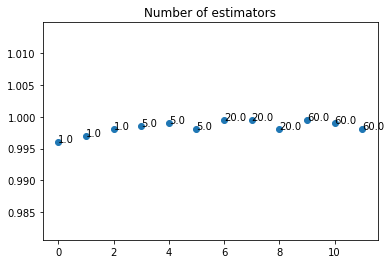

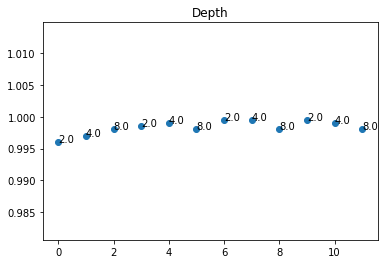

In [24]:
from sklearn.ensemble import AdaBoostClassifier

configs = []

for nr_of_estimators in [1, 5, 20, 60]:
    for depth in [2, 4, 8]:
        dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=0)
        adaboost_clr = AdaBoostClassifier(base_estimator=dt, n_estimators=nr_of_estimators, learning_rate=0.5, random_state=0)
        adaboost_clr.fit(selected_x_train, selected_y_train)
        adaboost_acc = adaboost_clr.score(selected_x_test, selected_y_test)
        configs.append(np.array([nr_of_estimators, depth, adaboost_acc]))

configs = np.array(configs)
        
for idx, txt in enumerate(["Number of estimators", "Depth"]):
    plt.scatter(list(range(len(configs))), configs[:,-1])
    for i in range(len(configs)):
        plt.annotate(configs[i][idx], (i, configs[i][-1]))
    plt.title(txt)
    plt.show()

# Performance and complexity

We observe that the more the number of estimators increases (from 1 to 5 to 20 to 60), we want these estimators to have a lower depth (2 or 4). 

In [27]:
rf = RandomForestClassifier(criterion='gini', n_estimators=20, max_depth=10, bootstrap=True, random_state=0)
rf.fit(x_train, y_train)
rf_acc = rf.score(x_test, y_test)

print(rf_acc)

dt = DecisionTreeClassifier(criterion="gini", max_depth=10, random_state=0)
adaboost_clr = AdaBoostClassifier(base_estimator=dt, n_estimators=30, learning_rate=0.3, random_state=0)
adaboost_clr.fit(x_train, y_train)
adaboost_acc = adaboost_clr.score(x_test, y_test)

print(adaboost_acc)

0.8407
0.8077


# AdaBoost and RandomForest - all labels
First of all, as we are using all labels now for training/testing, we will switch to the Gini Impurity method for the underlying Decision Trees.

# Theoretical comparison - RandomForestClassifier and AdaBoostClassifier

Both Decision Forests and Adaboost are ensamble methods, but the first one is parallel, while the second is sequential. Decision Forests are a form of bagging, so the way they work is by training a number of unstable (high-variance) weak learners with low bias and aggregating their results, thus creating stability (minimising variance). With AdaBoost you create a pipeline that you use to gradually improve a weak learner by adaptatively reweighting training data prior to training it. In essence, Adaboost trains a sequence of simple models, but the sum of simple models is complex/accurate. Thus, unlike Decision Forests, AdaBoost prefers weak learners with low variance and high bias.